In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!cp "/content/drive/My Drive/lfw.zip" "/content/"

In [8]:
import zipfile
with zipfile.ZipFile("/content/lfw.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")
path = 'lfw'

In [9]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [10]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU.")

MPS device not found.
Using GPU: Tesla T4


torch.Size([250, 250, 3])


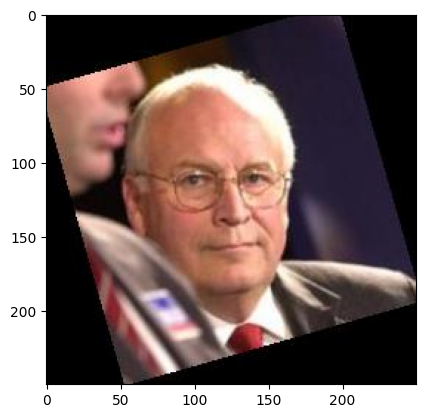

In [11]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

#Ans:
While AutoEncoders focus on deterministic mappings and are often used for reconstruction tasks, Variational AutoEncoders introduce probabilistic components, making them suitable for generative tasks and ensuring the learned latent space is structured and capable of generating novel samples.

Applications:-
* AutoEnoders are primarily used for data compression and feature learning.
It encodes input data into a loew-dimensional representation and then decodes it back to original data.
It is useful for tasks like dimensionality reduction, feature extraction and image denoising.

* Variational AutoEncoders extend AutoEncoders by introducing probabilistic components.
VAEs are designed for generative modeling and have applications in generating new data samples.
Useful for generating diverse and realistic samples from the learned latent space.

Architecture:-
* In AutoEncoders, the encoder-decoder architecture learns a deterministic mapping from input to latent space and back.
The encoder produces a fixed encoding for each input, and the decoder attempts to recontruct the input based on this encoding.

* Variational AutoEncoder, in addition to the encoder-decoder structure, introduces a probabilistic layer in the encoder.
Instead of producing a fixed encoding, VAE's encoder outputs the mean and log variance of a distribution in the latent space.
The model then samples from this distribution during training and generates diverse representations.

Loss Function:-
* AutoEncoders typically use Mean Squared Error (MSE) loss for reconstruction. The goal is to minimize the difference between the input and the reconstructed output.

* Variational AutoEncoders (VAE) employ a combination of two losses - reconstruction loss (MSE) and the Kullback-Leibler (KL) divergence loss.
The reconstruction loss aims to reconstruct the input faithfully, while the KL divergence loss regularizes the latent space, making it follow a standard normal distribution.
The KL divergence encourages the model to learn a well-behaved latent space, aiding in the generation of new samples.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [12]:
import torch.nn.functional as F

class VAE(nn.Module):

    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(128 * 32 * 32, latent_dim)
        self.fc_log_var = nn.Linear(128 * 32 * 32, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 128 * 32 * 32)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),  # Sigmoid for output in [0, 1]
        )

    def encoder(self, x):
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, x):
        x = self.decoder_fc(x)
        x = x.view(x.size(0), 128, 32, 32)
        return self.decoder_conv(x)

    def forward(self, x):
        # Encoder
        mu, log_var = self.encoder(x)

        # Reparameterization
        z = self.reparameterize(mu, log_var)

        # Decoder
        #z_reshaped = z.view(z.size(0), -1)
        x_recon = self.decoder(z)

        return x_recon, mu, log_var

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

#Ans

* In a Variational AutoEncoder, the encoder outputs the mean('mu') and log variance('log_var') of a multivariate Gaussian distribution in the latent space and introduces stochasticity by modeling the latent space as a probability distribution. .

* To generate new samples, instead of directly sampling from the learned distribution, we sample from a standard normal distribution (N(0, 1)) and then transform the samples to align with the parameters of the learned distribution. The reparameterization trick is crucial because it allows the model to be trained end-to-end using gradient descent while maintaining differentiability.

* By sampling from a standard normal distribution and then transforming the samples using the mean and log variance, we ensure that the model's parameters can be updated through backpropagation. This technique enables the VAE to generate diverse and realistic samples from the learned latent space during both training and inference.

# input_image = x.permute(2, 0, 1).unsqueeze(0).to(device)
* We have taken an input image and processed it to fit the model's input requirements and mounted it to device(cuda).
* The processed inout image is then passed to the VAE model for processing.

# output_image, mu, log_var = model(input_image)

* During the forward pass, the input image is encoded into a latent space representation by the encoder part of the VAE.
* The encoder outputs two crucial parameters: the mean (mu) and the log variance (log_var). These parameters define a multivariate Gaussian distribution in the latent space.

# z_sampled = model.reparameterize(mu, log_var)

* Random samples (z_sampled) are drawn from a standard normal distribution (N(0, 1)).
* The reparameterization trick is applied, transforming the random samples to align with the learned distribution defined by mu and log_var.

# generated_image = model.decoder(z_sampled)

* The sampled latent space representation (z_sampled) is passed through the decoder component of the VAE.
* The decoder aims to reconstruct an image from the sampled latent space, generating a new image (generated_image).
* The output of the decoder represents the VAE's attempt to create a new image based on the learned distribution in the latent space.


In [13]:
model = VAE(latent_dim=20).to(device)

In [14]:
# Pass an image to the model
input_image = x.permute(2, 0, 1).unsqueeze(0).to(device)

# Forward pass through the VAE
output_image, mu, log_var = model(input_image)

# Print the shape of the output of the encoder
print("Encoder Output Shapes - Mean:", mu.shape, "\nLog Variance:", log_var.shape)

# Sample from the latent space
z_sampled = model.reparameterize(mu, log_var)

# Use the decoder to generate new images from the sampled latent space
generated_image = model.decoder(z_sampled)

# Print the shape of the output of the decoder
print("Decoder Output Shape:", generated_image.shape)

Encoder Output Shapes - Mean: torch.Size([1, 20]) 
Log Variance: torch.Size([1, 20])
Decoder Output Shape: torch.Size([1, 3, 256, 256])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.

#Ans:
* The loss function is a combination of two components: the Reconstruction Loss and the KL Divergence Loss.

# reconstruction_loss = F.mse_loss(output_image, input_image_resized, reduction='sum')

* The Reconstruction Loss measures how well the VAE can reconstruct the input data. It encourages the model to generate output images that closely resemble the original input images.
* This term is calculated using Mean Squared Error (MSE) or a similar loss function. It compares the pixel-wise similarity between the generated image and the original input image. Minimizing this loss drives the VAE to produce accurate reconstructions.
* It ensures that the VAE is effective at reconstructing input data.

# kl_divergence_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

* The KL Divergence Loss regularizes the latent space by encouraging it to follow a specific distribution (usually a standard normal distribution). This helps in making the latent space more structured and aids in better sampling during generation.
* KL Divergence measures the difference between the distribution of the learned latent space and a standard normal distribution. Minimizing this loss encourages the latent space to be close to a unit Gaussian, promoting smoothness and aiding in meaningful interpolation during generation.
* It encourages a well-behaved and structured latent space.

# loss_function = (reconstruction_loss + kl_divergence_loss)

* The Total Loss is the sum of the Reconstruction Loss and the KL Divergence Loss. It balances the trade-off between accurately reconstructing input data and regularizing the latent space.
* By combining the Reconstruction Loss and KL Divergence Loss, the VAE aims to strike a balance. The model should generate accurate reconstructions while ensuring the latent space adheres to a desired distribution. This balance is crucial for the VAE to learn a meaningful latent space representation.
* The Total Loss combines these objectives, creating a holistic training signal for the VAE.

* create an optimizer for training

In [15]:
total_params_vae = sum(p.numel() for p in model.parameters())
print(f"Total Number of Parameters in VAE: {total_params_vae}")

Total Number of Parameters in VAE: 8181803


In [16]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
input_image_resized = F.interpolate(input_image, size=(256, 256), mode='bilinear', align_corners=False).to(device)

# Reconstruction Loss:
reconstruction_loss = F.mse_loss(output_image, input_image_resized, reduction='sum')

# KL Divergence Loss:
kl_divergence_loss = -1 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

# Total Loss:
loss_function = (reconstruction_loss + kl_divergence_loss)

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

#Ans

* If the loss is not decreasing during training, it indicates potential challenges in the learning process that need troubleshooting. First, it's crucial to assess the learning rate as it plays a pivotal role in determining the model's convergence. Experimenting with different learning rates, either reducing or increasing, can help achieve a more appropriate balance.
* Additionally, the model's complexity may impact its ability to capture patterns in the data. Adjusting the architecture based on the complexity of the dataset, avoiding models that are either too simple or too complex, can enhance performance.
* Data quality is another factor to consider; thorough examination of preprocessing steps, normalization, and potential outliers is essential.
* Trying different loss functions or modifying the weighting of existing ones can provide insights into the most effective approach for the given problem.
* Evaluating the model's capacity, experimenting with hyperparameters, implementing regularization techniques to prevent overfitting, and monitoring individual loss components contribute to a systematic troubleshooting strategy.
* If necessary, increasing the training time cautiously or inspecting weight initialization for potential issues can also be beneficial. Systematically addressing these considerations allows for a more refined training process, improving convergence and reducing loss values.

In [18]:
num_epochs = 10

for epoch in range(num_epochs):
    total_reconstruction_loss = 0.0
    total_kl_divergence_loss = 0.0
    total_loss = 0.0

    for images, _ in dataloader:
        # Resize input images to match the output size of the VAE
        images_resized = F.interpolate(images, size=(256, 256), mode='bilinear', align_corners=False).to(device)

        # Forward pass
        output_images, mu, log_var = model(images_resized)

        # Reconstruction Loss
        reconstruction_loss = F.mse_loss(output_images, images_resized, reduction='sum')

        # KL Divergence Loss
        kl_divergence_loss = -1 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Total Loss using predefined loss function:
        total_loss = (reconstruction_loss + kl_divergence_loss)

        # Backward pass and optimization
        optim.zero_grad()
        total_loss.backward()
        optim.step()

        total_reconstruction_loss += reconstruction_loss.item()
        total_kl_divergence_loss += kl_divergence_loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Reconstruction Loss: {total_reconstruction_loss:.4f}, KL Divergence Loss: {total_kl_divergence_loss:.4f}, Total Loss: {total_loss:.4f}')

Epoch [1/10], Reconstruction Loss: 96196762.8984, KL Divergence Loss: 1601109.6001, Total Loss: 118486.6094
Epoch [2/10], Reconstruction Loss: 68055022.4688, KL Divergence Loss: 1611195.1094, Total Loss: 111023.9141
Epoch [3/10], Reconstruction Loss: 66020851.8594, KL Divergence Loss: 1607902.8911, Total Loss: 100256.9297
Epoch [4/10], Reconstruction Loss: 64823537.2422, KL Divergence Loss: 1619500.8555, Total Loss: 117351.2266
Epoch [5/10], Reconstruction Loss: 63897032.8125, KL Divergence Loss: 1627207.6084, Total Loss: 125645.1953
Epoch [6/10], Reconstruction Loss: 63095131.3750, KL Divergence Loss: 1630623.1587, Total Loss: 110103.7578
Epoch [7/10], Reconstruction Loss: 62343879.4297, KL Divergence Loss: 1638256.1370, Total Loss: 100099.1641
Epoch [8/10], Reconstruction Loss: 61648866.3594, KL Divergence Loss: 1643415.1992, Total Loss: 93359.7422
Epoch [9/10], Reconstruction Loss: 61059404.6016, KL Divergence Loss: 1648097.8826, Total Loss: 93912.8438
Epoch [10/10], Reconstruction 

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

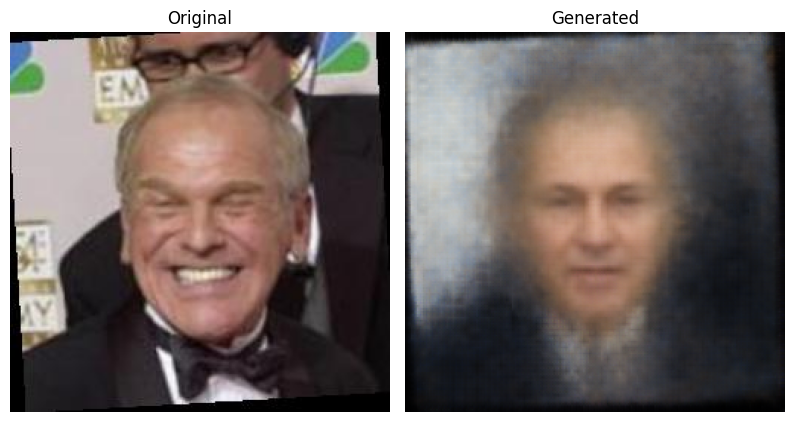

In [30]:
# Set the model to evaluation mode
model.eval()

# Choose a random image from the dataset
random_index = random.randint(0, len(dataloader.dataset) - 1)
random_image, _ = dataloader.dataset[random_index]

# Move the random image to the GPU
random_image = random_image.unsqueeze(0).to(device)

# Generate the encoded representation of the random image
with torch.no_grad():
    mu, log_var = model.encoder(random_image)

# Reparameterize to obtain the encoded image
encoded_image = model.reparameterize(mu, log_var)

# Generate new samples from the encoded image's latent space using the decoder
with torch.no_grad():
    generated_samples_from_encoded = model.decoder(encoded_image)

# Move generated samples back to CPU for plotting
generated_samples_from_encoded_cpu = generated_samples_from_encoded.cpu()

# Plot the random image, encoded image, and generated samples
plt.figure(figsize=(12, 6))

num_samples = 5  # Number of samples to generate

# Plot the original random image
plt.subplot(1, 3, 1)
plt.imshow(random_image.squeeze().cpu().numpy().transpose(1, 2, 0))
plt.title("Original")
plt.axis('off')

# Plot the generated samples from the encoded image's latent space
plt.subplot(1, 3, 2)
plt.imshow(generated_samples_from_encoded_cpu.squeeze().numpy().transpose(1, 2, 0))
plt.title(f"Generated")
plt.axis('off')

plt.tight_layout()
plt.show()